In [10]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Augmentation을 적용한 데이터셋 만들기
- 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

In [12]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

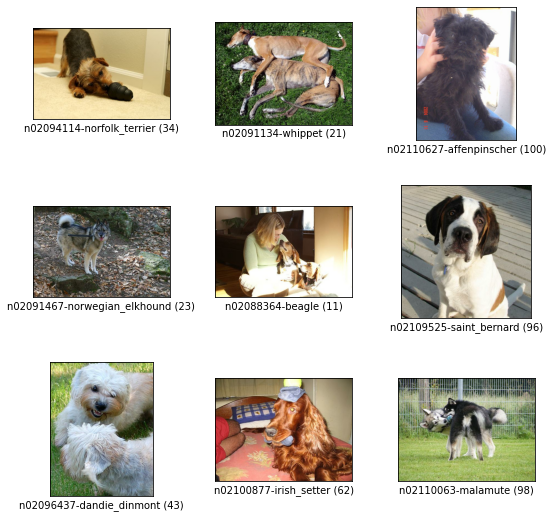

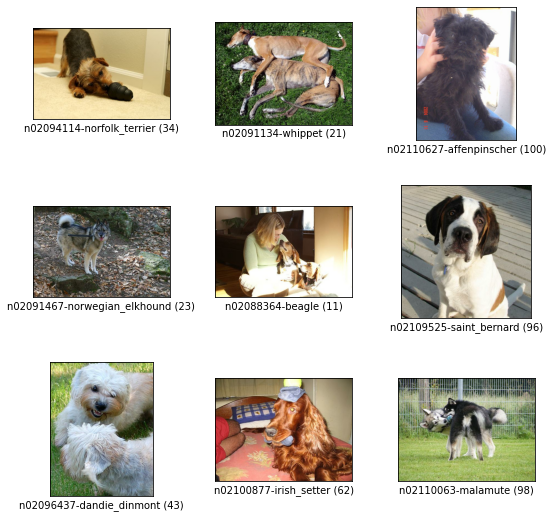

In [13]:
tfds.show_examples(ds_train, ds_info)

In [14]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    # One-hot encode the label
    label = tf.one_hot(label, num_classes)
    return image, label

In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [16]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [17]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [18]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [19]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

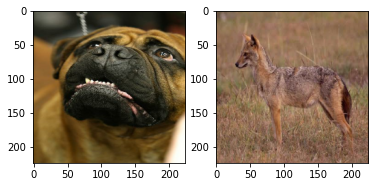

In [20]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [21]:
# CutMix 적용
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    batch_size = int(batch_size)
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [22]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(171, shape=(), dtype=int32) tf.Tensor(217, shape=(), dtype=int32)
y :  tf.Tensor(85, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


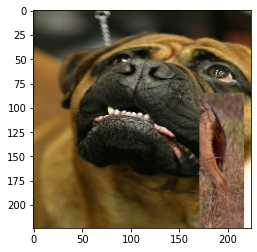

In [23]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [24]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [25]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

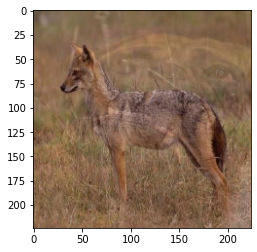

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.16579497 0.         0.         0.
 0.         0.         0.         0.         

In [26]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [27]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 2. 모델 만들기
- 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [28]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [29]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [30]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

# 3. 모델 훈련하기
- 모델을 훈련시켜 주세요.
- 주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=2,         
    restore_best_weights=True
)

# 학습 파라미터
EPOCH = 20

# 모델 컴파일 및 훈련 (증강 미적용)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,  # 증강 없이 학습
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[early_stopping]  
)

Epoch 1/20
750/750 [==============================] - 197s 200ms/step - loss: 2.2170 - accuracy: 0.4479 - val_loss: 3.2621 - val_accuracy: 0.2183
Epoch 2/20
750/750 [==============================] - 153s 205ms/step - loss: 0.7709 - accuracy: 0.7809 - val_loss: 1.1411 - val_accuracy: 0.6673
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2444 - accuracy: 0.9471 - val_loss: 0.9297 - val_accuracy: 0.7288
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0668 - accuracy: 0.9931 - val_loss: 0.8978 - val_accuracy: 0.7399
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0267 - accuracy: 0.9985 - val_loss: 0.9220 - val_accuracy: 0.7437
Epoch 6/20
750/750 [==============================] - 169s 225ms/step - loss: 0.0169 - accuracy: 0.9995 - val_loss: 0.9189 - val_accuracy: 0.7485


In [33]:
# 모델 컴파일 및 훈련 (증강 적용)
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,  # 증강을 사용한 학습
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[early_stopping]  
)

Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 2.2834 - accuracy: 0.4248 - val_loss: 2.7947 - val_accuracy: 0.2994
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 0.9717 - accuracy: 0.7232 - val_loss: 1.1458 - val_accuracy: 0.6664
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.5227 - accuracy: 0.8587 - val_loss: 1.3452 - val_accuracy: 0.6230
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2818 - accuracy: 0.9335 - val_loss: 1.0175 - val_accuracy: 0.7109
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.1583 - accuracy: 0.9677 - val_loss: 0.9527 - val_accuracy: 0.7254
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0873 - accuracy: 0.9862 - val_loss: 1.0081 - val_accuracy: 0.7213
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0820 - accuracy: 0.9868 - val_loss: 0.9913 -

# 4. 훈련 과정 시각화하기
- 훈련 과정의 히스토리를 그래프로 시각화해 주세요.

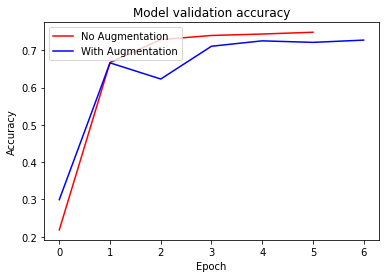

In [34]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

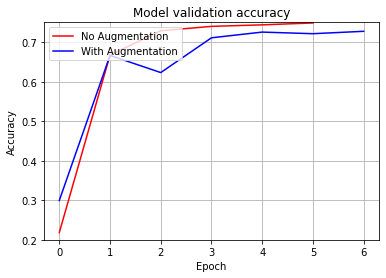

In [35]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.2, 0.75)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

# 5. Augmentation에 의한 모델 성능 비교
- No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

In [31]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np

# Stanford Dogs 데이터셋 로드
(ds_train, ds_val), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# 클래스 수 정의
num_classes = ds_info.features['label'].num_classes
IMG_SIZE = 224

# 전처리 함수 정의
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    label = tf.one_hot(label, depth=num_classes)
    return image, label

# 전처리 및 배치 처리
batch_size = 32
ds_train = ds_train.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 콜백 정의
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ResNet 모델 생성 함수 정의
def create_resnet_model(fine_tune_at=100, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# 데이터 증강 및 모델 훈련
augmentation_methods = ['No Augmentation', 'Basic Augmentation', 'Basic + CutMix', 'Basic + Mixup']
histories = []

for method in augmentation_methods:
    print(f"훈련 시작: {method}")
    model = create_resnet_model()
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss=CategoricalCrossentropy(), 
                  metrics=['accuracy'])
    
    # 증강 방법 설정
    ds_augmented_train = ds_train
    if method == 'Basic Augmentation':
        ds_augmented_train = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    elif method == 'Basic + CutMix':
        ds_augmented_train = ds_train.map(lambda image, label: cutmix(image, label, batch_size=batch_size, img_size=IMG_SIZE, num_classes=num_classes), num_parallel_calls=tf.data.AUTOTUNE)
    elif method == 'Basic + Mixup':
        ds_augmented_train = ds_train.map(lambda image, label: mixup(image, label, batch_size=batch_size, img_size=IMG_SIZE, num_classes=num_classes), num_parallel_calls=tf.data.AUTOTUNE)

    # fit 메서드에서 Dataset 객체를 validation_data로 사용
    history = model.fit(ds_augmented_train,
                        validation_data=ds_val,
                        epochs=20,
                        steps_per_epoch=len(ds_train) // batch_size,
                        validation_steps=len(ds_val) // batch_size,
                        callbacks=[reduce_lr, early_stopping])
    histories.append((method, history))

훈련 시작: No Augmentation
Epoch 1/20
11/11 [==============================] - 7s 318ms/step - loss: 4.9773 - accuracy: 0.0085 - val_loss: 4.7792 - val_accuracy: 0.0234
Epoch 2/20
11/11 [==============================] - 3s 239ms/step - loss: 4.7883 - accuracy: 0.0142 - val_loss: 4.7681 - val_accuracy: 0.0039
Epoch 3/20
11/11 [==============================] - 3s 237ms/step - loss: 4.7618 - accuracy: 0.0284 - val_loss: 4.7356 - val_accuracy: 0.0117
Epoch 4/20
11/11 [==============================] - 3s 240ms/step - loss: 4.7192 - accuracy: 0.0284 - val_loss: 4.6078 - val_accuracy: 0.0703
Epoch 5/20
11/11 [==============================] - 3s 241ms/step - loss: 4.5536 - accuracy: 0.0540 - val_loss: 4.4915 - val_accuracy: 0.0781
Epoch 6/20
11/11 [==============================] - 3s 238ms/step - loss: 4.3258 - accuracy: 0.0881 - val_loss: 4.2125 - val_accuracy: 0.0898
Epoch 7/20
11/11 [==============================] - 3s 239ms/step - loss: 4.0421 - accuracy: 0.1250 - val_loss: 3.9897 - val_

NameError: name 'plot_training_history' is not defined

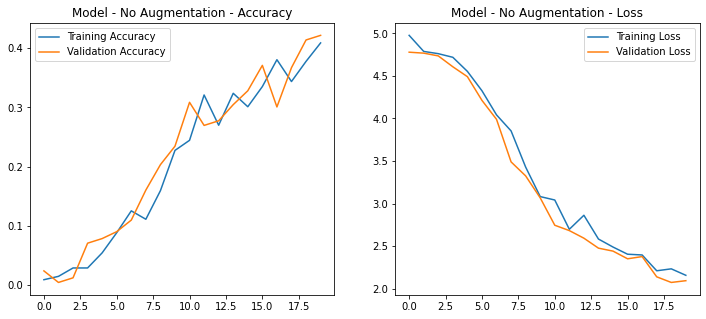

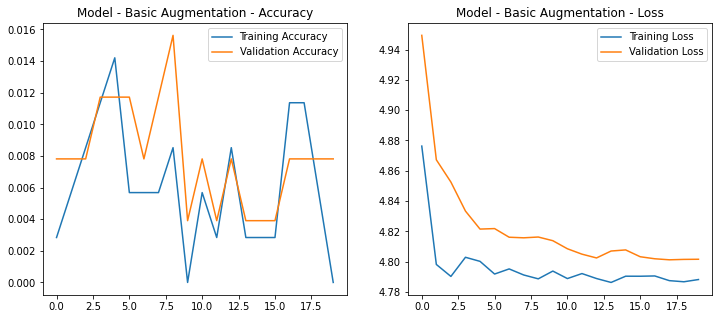

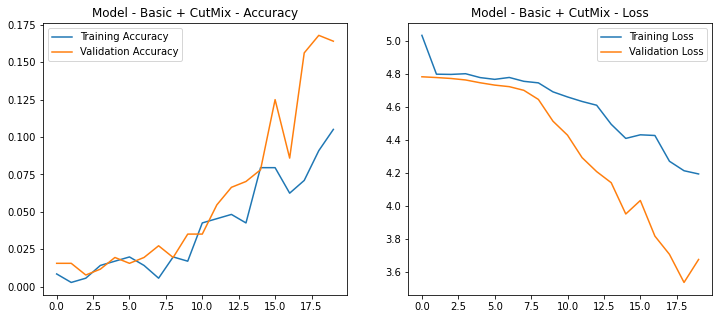

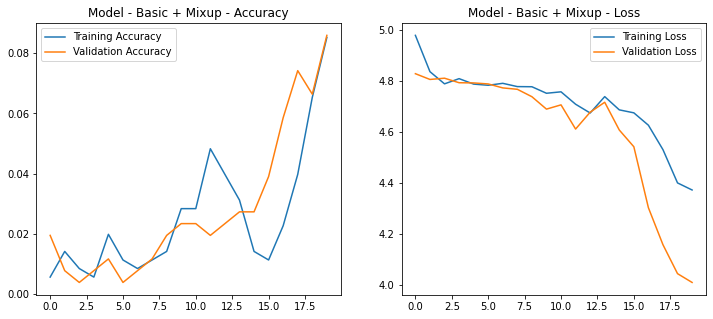

In [32]:
# 학습 결과 시각화 함수 정의
def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

# 학습 결과 시각화
for method, history in histories:
    plot_training_history(history, f'Model - {method}')

# 1. No Augmentation
- 훈련 및 검증 정확도: 비교적 느리게 증가하며, 검증 정확도가 안정적임.
- 훈련 및 검증 손실: 손실은 지속적으로 감소하며, 과적합의 징후가 적게 보임.
- 결과 분석: Augmentation 없이 훈련된 모델은 안정적인 검증 성능을 보였지만, 더 높은 성능을 얻기 위해서는 Augmentation이 필요함.

# 2. Basic Augmentation
- 훈련 및 검증 정확도: 검증 정확도가 훈련 정확도보다 낮고 변동이 큼.
- 훈련 및 검증 손실: 훈련 초기에 손실이 급격히 감소하나 검증 손실의 변동폭이 큼.
- 결과 분석: 기본 Augmentation을 통해 데이터 다양성을 높였으나, 불안정한 정확도와 손실 그래프가 나타나 과적합 방지를 위한 추가적인 방법이 필요할 수 있음.

# 3. Basic + CutMix
- 훈련 및 검증 정확도: 학습 중후반에 검증 정확도가 향상되며 훈련 정확도에 비해 높게 나타남.
- 훈련 및 검증 손실: 검증 손실이 지속적으로 감소하여 훈련 손실과 유사하게 수렴함.
- 결과 분석: CutMix 적용은 데이터 다양성 확보에 효과적이었으며, 검증 성능이 전반적으로 안정적으로 향상되었음.
    
# 4. Basic + Mixup
- 훈련 및 검증 정확도: 훈련 정확도가 매우 높게 상승하는 반면, 검증 정확도는 비교적 낮은 수준으로 유지됨.
- 훈련 및 검증 손실: 검증 손실이 증가하는 경향을 보여 과적합이 발생할 가능성이 있음을 시사함.
- 결과 분석: Mixup을 사용했을 때 검증 정확도가 감소하고 손실이 일정 수준에 머무는 경향을 보임. 이 결과는 Mixup이 데이터셋의 다양성은 높였으나 모델이 학습에 어려움을 겪었을 수 있음을 시사함.

# 회고

#### 에폭 기다리는 것이 너무 지쳤다.
#### CutMix와 Mixup을 이해하는 것도 조금 힘들었다.
#### 이때까지 한 프로젝트 중 가장 마음에 들지 않는다...